In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from imp import reload
%run lesson_function.py
#rereload(lesson_function.bin_spatial);load(lesson_function.bin_spatial);
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split


%matplotlib inline


C:\Users\Rahul\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Read in cars and notcars
images = glob.glob('vehicles/*/*.png')

cars = []
notcars = []
for image in images:
    cars.append(image)
    
images = glob.glob('non-vehicles/*/*.png')  
for image in images:
    notcars.append(image)

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
#sample_size = 10
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]


print(len(cars))
print(len(notcars))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 3000
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

8792
8968


In [3]:


### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial = 16
histbin = 16
#spatial_size = (32, 32) # Spatial binning dimensions
#hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
#y_start_stop = [450, 700] # Min and max in y to search in slide_window()
y_start_stop = [400, 656] # Min and max in y to search in slide_window()


In [4]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)




In [5]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    





In [6]:
%run lesson_function.py
# Read in cars and notcars


t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=(spatial,spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract_features car...')

print("car extraction done")

33.19 Seconds to extract_features car...
car extraction done


In [7]:
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=(spatial,spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract_features 3000 no car...')

print("car extraction done")

25.85 Seconds to extract_features 3000 no car...
car extraction done


In [8]:

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()


Using: 8 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5520
1.11 Seconds to train SVC...
Test Accuracy of SVC =  0.9967


In [9]:
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 15
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('Labels        ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Test Accuracy of SVC =  0.9967
SVC predicts:  [ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.]
Labels         [ 0.  1.  0.  0.  0.  1.  0.  0.  1.  0.  1.  0.  0.  0.  0.]
0.00501 Seconds to predict 15 labels with SVC


In [10]:
print('X_train.shape',X_train.shape)

print('X_test.shape',X_test.shape)

X_train.shape (4800, 5520)
X_test.shape (1200, 5520)


In [11]:
import pickle

pickle.dump( svc, open( "saved_svc.p", "wb" ) )
pickle.dump( X_train, open( "saved_X_scaler.p", "wb" ) )
pickle.dump( X_test, open( "saved_XTest_scaler.p", "wb" ) )

In [12]:
import pickle
loaded_svc = pickle.load( open( "saved_svc.p", "rb" ) )
loaded_X_scale = pickle.load( open( "saved_X_scaler.p", "rb" ) )
loaded_XTest_scale = pickle.load( open( "saved_XTest_scaler.p", "rb" ) )

In [13]:
print('loaded_X_scale.shape',loaded_X_scale.shape)

print('loaded_XTest_scale.shape',loaded_XTest_scale.shape)


loaded_X_scale.shape (4800, 5520)
loaded_XTest_scale.shape (1200, 5520)


(256, 1280, 3)


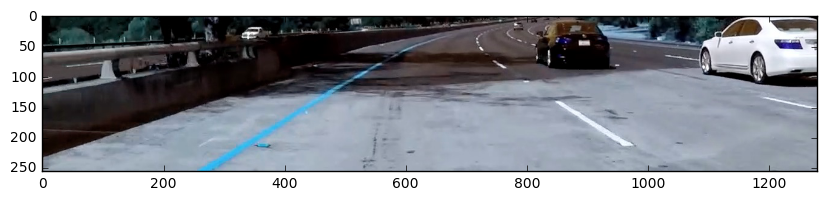

In [14]:
fname = 'test_images/test{}.jpg'.format(5)
image_test = cv2.imread(fname)
img_tosearch = image_test[400:656,:,:]
plt.figure(figsize=(10,10))
plt.imshow(img_tosearch)
print(img_tosearch.shape)


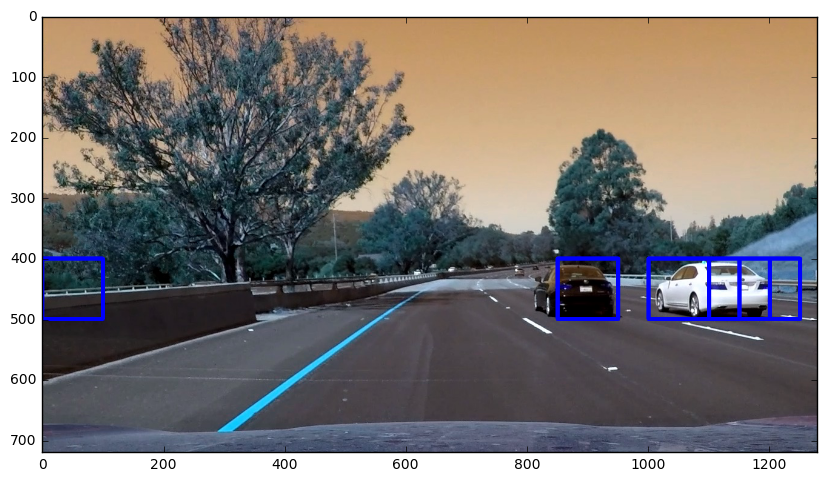

In [15]:

fname = 'test_images/test{}.jpg'.format(6)
image = cv2.imread(fname)
draw_image = np.copy(image)
# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
                    xy_window=(100, 100), xy_overlap=(0.5, 0.5))
# for loaded svc search
# hot_windows = search_windows(image, windows, loaded_svc, loaded_X_scale, color_space=color_space, 
#                         spatial_size=(spatial,spatial), hist_bins=histbin, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)   


hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=(spatial,spatial), hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  

plt.figure(figsize=(10,10))
plt.imshow(window_img)



20


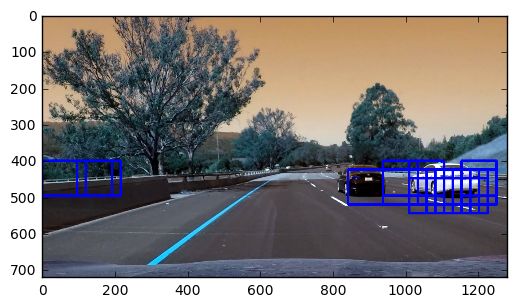

In [16]:
# Define a single function that can extract features using hog sub-sampling and make predictions
#%run lesson_function.py
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    count = 0
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    boxes =[]
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)-1
    nyblocks = (ch1.shape[0] // pix_per_cell)-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
#     print('hog3.shape',hog3.shape)
#     print('hog2.shape',hog2.shape)
#     print('hog1.shape',hog1.shape)
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            #print('hog_features.shape',hog_features.shape)
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            #Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            #test_features = X_scaler.transform(hog_features).reshape(1, -1)   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                count = count+1
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
    return boxes,count
    
ystart = 400
ystop = 656
scale = 1.5



fname = 'test_images/test{}.jpg'.format(6)
image = cv2.imread(fname)
draw_image = np.copy(image  )  
boxes,count = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                    (spatial,spatial), histbin)
print(len(boxes))
out_img = draw_boxes(image, boxes, color=(0, 0, 255), thick=6)
plt.imshow(out_img)

43
((0, 400), (70, 470))
((17, 400), (87, 470))
((35, 400), (105, 470))
((52, 400), (122, 470))
((52, 417), (122, 487))
((70, 400), (140, 470))
((70, 417), (140, 487))
((105, 417), (175, 487))
((140, 400), (210, 470))
((264, 400), (334, 470))
((281, 400), (351, 470))
((299, 400), (369, 470))
((334, 400), (404, 470))
((510, 417), (580, 487))
((545, 400), (615, 470))
((598, 417), (668, 487))
((616, 417), (686, 487))
((809, 435), (879, 505))
((827, 435), (897, 505))
((862, 417), (932, 487))
((880, 417), (950, 487))
((968, 417), (1038, 487))
((1003, 435), (1073, 505))
((1020, 417), (1090, 487))
((1020, 435), (1090, 505))
((1038, 400), (1108, 470))
((1056, 435), (1126, 505))
((1073, 435), (1143, 505))
((1091, 435), (1161, 505))
((1126, 435), (1196, 505))
((1144, 435), (1214, 505))
((1161, 435), (1231, 505))
((1179, 417), (1249, 487))
((1179, 435), (1249, 505))
((0, 400), (89, 489))
((44, 400), (133, 489))
((67, 400), (156, 489))
((89, 400), (178, 489))
((268, 400), (357, 489))
((313, 400), 

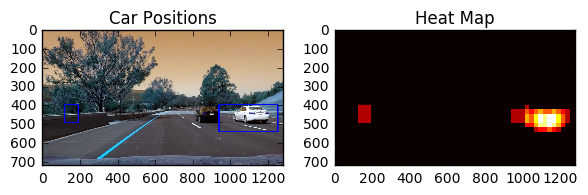

In [19]:

from scipy.ndimage.measurements import label
#%run lesson_function.py
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

# Read in image similar to one shown above 
#image = mpimg.imread('test_image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)



# Add heat to each box in box list
heat = add_heat(heat,boxes)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
#print(labels[1])
draw_img = draw_labeled_bboxes(np.copy(image), labels)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()


20


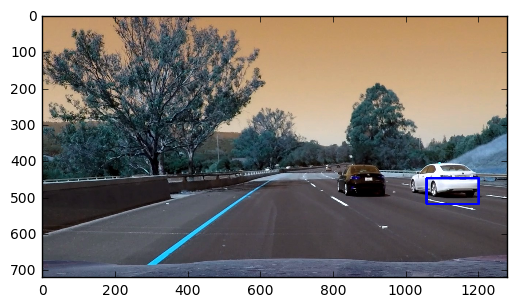

In [65]:
%run lesson_function.py
nframes = 10
bbox_frames =[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0

def Process_image(image):
    global counter
    global bbox_frames
    
    counter = counter+1
    countFrame = counter % nframes
    
    #Find rectangles for one image
    #bbox1 = find_cars_multiple(img, ystart, ystop, svc, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, cspace, X_scaler)
    boxes,count = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block,
                    (spatial,spatial), histbin)
    #print((count))
        
    #Store the rectangles of the frame
    bbox_frames[countFrame] = boxes
    threshold =5
    out_HeatImg = add_heatMap(image, boxes,threshold)
    
    #Sum rectangles of the nframes
    bbox2=[]
    for box in bbox_frames:
        if box!=0:
            for b in box:
                bbox2.append(b)
    #print("len boxex over frame",bbox2,counter)
    
    #Find heatmap of average
    thres = 8
    out_HeatImg = add_heatMap(image,bbox2, thres)
    
    return out_HeatImg

fname = 'test_images/test{}.jpg'.format(6)
image = cv2.imread(fname)
out_HeatImg = Process_image(image)
print(len(boxes))
#out_img = draw_boxes(image, boxes, color=(0, 0, 255), thick=6)
plt.imshow(out_HeatImg)

# fig = plt.figure()
# plt.subplot(121)
# plt.imshow(draw_img)
# plt.title('Car Positions')
# plt.subplot(122)
# plt.imshow(heat_map, cmap='hot')
# plt.title('Heat Map')
# fig.tight_layout()

In [39]:

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import moviepy as mve

In [64]:
# #Create video file pipeline
counter=0
nframes = 25


bbox_frames=[]
#Inicialization of list
for i in range(nframes):
    bbox_frames.append(0)
counter = 0


output = 'out_project_video_subclip.mp4'
clip1 = VideoFileClip("project_video.mp4").subclip(1,7)
#clip1 = VideoFileClip("test_video.mp4",audio = False)#.subclip(10,11)

out_clip = clip1.fl_image(Process_image) #NOTE: this function expects color images!!
%time out_clip.write_videofile(output, audio=False)
print("done")

[MoviePy] >>>> Building video out_project_video_subclip.mp4
[MoviePy] Writing video out_project_video_subclip.mp4


 99%|███████████████████████████████████████▋| 150/151 [01:37<00:00,  1.36it/s]  1%|▎                                         | 1/151 [00:00<01:30,  1.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: out_project_video_subclip.mp4 

Wall time: 1min 40s
done


In [62]:
HTML("""
<video  width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

In [63]:

#Save clip 
myclip = clip1.to_ImageClip(t='00:01:06') # frame at t=1 hour.
myclip.save_frame("frame06.jpeg")